<a href="https://colab.research.google.com/github/dtminnick/pytorch-practice/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deep Learning - Manually Graded Assignment 1**

Donnie Minnick

October 2025

# Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Load and Normalize the MNIST Data

Use **transforms.ToTensor()** to convert the PIL images to PyTorch tensors; scale pixel values from [0, 255] to [0.0, 1.0].

Use **transforms.Normalize((0.5,), (0.5,))** to normalize the tensors to have values in the range [-1.0, 1.0], assuming the original data is centered around 0.5.

Apply normalization during data load.

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),
                                 (0.5,))])

# Get training data.

training_data = datasets.MNIST(root = "./data",
                            train = True,
                            download = True,
                            transform = transform)

# Get testing data.

testing_data = datasets.MNIST(root = "./data",
                           train = False,
                           download = True,
                           transform = transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.24MB/s]


Confirm download of training data.

In [4]:
print("Training set size:", len(training_data))

Training set size: 60000


Confirm download of test data.

In [5]:
print("Testing set size:", len(testing_data))

Testing set size: 10000


# Split Data

Split the data into training, validation and testing sets.

A testing set already exists; randomly take 10,000 images from the training set and reserve them as a validation set.

In [6]:
train_size = 50000
val_size = 10000

training_data, validation_data = random_split(training_data, [train_size, val_size])

Confirm splits.

In [7]:
print("Training set size:", len(training_data))
print("Validation set size:", len(validation_data))
print("Testing set size:", len(testing_data))

Training set size: 50000
Validation set size: 10000
Testing set size: 10000


# Build a CNN network

Build a CNN network with convolution layers, pooling layers to classify the number.

## Setup Data Loaders

Batch training and validation data with batch_size = 64. Shuffle training data for generalization; validation data is not shuffled, ensuring consistent evaluation.

In [20]:
batch_size = 64

training_loader = DataLoader(training_data, batch_size = batch_size, shuffle = True)

validation_loader = DataLoader(validation_data, batch_size = batch_size, shuffle = False)

testing_loader = DataLoader(testing_data, batch_size = batch_size, shuffle = False)

## Create Model Class



In [9]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size, stride)
        self.conv2 = nn.Conv2d(6, 16, kernel_size, stride)

        # Compute the flattened size dynamically later if needed
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(x.size(0), -1)  # Dynamic flattening based on batch size
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

# Create Model Instance

Set seed and create model instance.

In [10]:
torch.manual_seed(91210)

model = ConvolutionalNetwork(kernel_size = 5, stride = 1)

model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Create Feature Map Tracer

Confirm output dimensions for any kernel/stride combo, auto-compute fc1 input size, and log shape evolution for interpretability.

In [11]:
def trace_feature_map(conv1, conv2, sample):
    x = sample.view(1, 1, 28, 28)  # Reshape to [batch, channel, height, width]
    print(f"Input shape: {x.shape}")

    x = F.relu(conv1(x))
    print(f"After conv1: {x.shape}")

    x = F.max_pool2d(x, 2, 2)
    print(f"After pool1: {x.shape}")

    x = F.relu(conv2(x))
    print(f"After conv2: {x.shape}")

    x = F.max_pool2d(x, 2, 2)
    print(f"After pool2: {x.shape}")

    flattened_size = x.view(1, -1).size(1)
    print(f"Flattened size: {flattened_size}")

    return flattened_size

## Trace Shape Evolution



In [12]:
# Grab one sample
X_sample, _ = next(iter(training_loader))
sample = X_sample[0]  # Single image from batch

# Trace shape evolution
flattened_size = trace_feature_map(model.conv1, model.conv2, sample)


Input shape: torch.Size([1, 1, 28, 28])
After conv1: torch.Size([1, 6, 24, 24])
After pool1: torch.Size([1, 6, 12, 12])
After conv2: torch.Size([1, 16, 8, 8])
After pool2: torch.Size([1, 16, 4, 4])
Flattened size: 256


## Loss Function Optimizer

Set up the loss function and optimizer for training the neural network.  Use a learning rate of 0.001.

In [13]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## Train Model



In [23]:
import time
start_time = time.time()

epochs = 5
training_losses = []
validation_losses = []
training_correct = []
validation_correct = []

# For loop of epochs

for i in range(epochs):
  trn_corr = 0
  val_corr = 0

  # Train

  for b, (X_train, y_train) in enumerate(training_loader):
    b += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b % 600 == 0:
      print(f'epoch: {i}  batch: {b}  loss: {loss.item()}')

  training_losses.append(loss)
  training_correct.append(trn_corr)

  # Test

  with torch.no_grad():
    for b,(X_validate, y_validate) in enumerate(validation_loader):
      y_val = model(X_validate)
      predicted = torch.max(y_val.data, 1)[1]
      val_corr += (predicted == y_validate).sum()

  loss = criterion(y_val, y_validate)
  validation_losses.append(loss)
  validation_correct.append(val_corr)

current_time = time.time()
total_time = current_time - start_time
print(f"Training took: {total_time / 60} minutes")

epoch: 0  batch: 600  loss: 0.0869385376572609
epoch: 1  batch: 600  loss: 0.02530621737241745
epoch: 2  batch: 600  loss: 0.0004866388044320047
epoch: 3  batch: 600  loss: 0.04413923621177673
epoch: 4  batch: 600  loss: 0.0036364072002470493
Training took: 2.032977569103241 minutes


# Plot Training and Validation Loss

Plot the training loss and validation loss as a function of epochs.

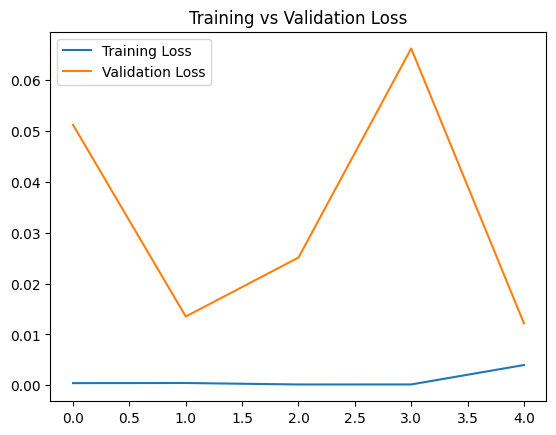

In [24]:
training_losses = [t.item() for t in training_losses]
validation_losses = [t.item() for t in validation_losses]
plt.plot(training_losses, label = "Training Loss")
plt.plot(validation_losses, label = "Validation Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot Training and Validation Accuracy

Plot the both training accuracy and validation accuracy as a function of epochs.

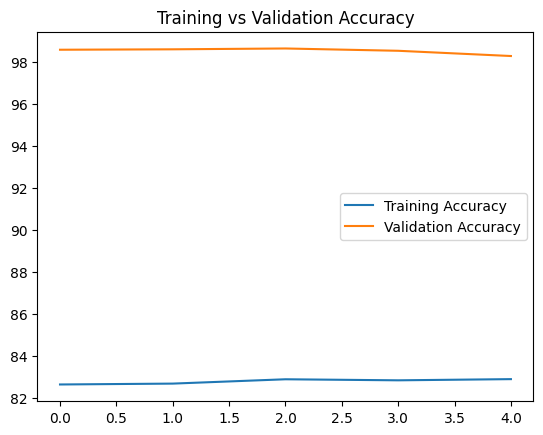

In [25]:
plt.plot([t/600 for t in training_correct], label = 'Training Accuracy')
plt.plot([t/100 for t in validation_correct], label = 'Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Show Testing Accuracy

Print the testing accuracy.

In [26]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in testing_loader:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()
  print(f'Test Accuracy: {correct/10000}')

Test Accuracy: 0.9848999977111816


# Implement Sweep Strategy

I will systematically vary key CNN hyperparameters — kernel size, stride, batch size, and learning rate — to assess their impact on training loss, validation accuracy, and feature map evolution. Each configuration is trained and evaluated using consistent data splits, with results logged for comparative analysis. This modular sweep enables principled experimentation, helping identify optimal architectural and training settings for improved model performance and stakeholder clarity.

In [ ]:
sweep_grid = {"kernel_size": [3, 5],
              "stride": [1, 2],
              "batch_size": [32, 64],
              "learning_rate": [0.001, 0.01]}

The sweep grid explores four key hyperparameters that influence CNN performance:

**Kernel Size: [3, 5]**

Tests the impact of local vs broader spatial feature extraction.

**Stride: [1, 2]**

Assesses how spatial resolution and downsampling affect learning.

**Batch Size: [32, 64, 128]**

Evaluates gradient stability, generalization, and training efficiency.

**Learning Rate: [0.001, 0.01]**

Measures convergence speed and sensitivity to weight updates.

This grid yields 24 unique configurations (2 × 2 × 3 × 2), each trained and evaluated to compare loss, accuracy, and feature map evolution. The goal is to identify optimal combinations for model performance and stakeholder clarity.

# Model Builder

Construct a CNN with specified kernel and stride. Modular for swapping architectures.

In [ ]:
def build_model(kernel_size, stride):
    feature_extractor = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=kernel_size, stride=stride),
        nn.ReLU(),
        nn.Conv2d(6, 16, kernel_size=kernel_size, stride=stride),
        nn.ReLU(),
        nn.Flatten()
    )

    flattened_size = compute_flattened_size(feature_extractor)

    return nn.Sequential(
        feature_extractor,
        nn.Linear(flattened_size, 10),
        nn.LogSoftmax(dim=1)
    )


# DataLoader Factory

Create DataLoaders with consistent batching. Keeps data handling clean and configurable.

In [ ]:
def create_dataloaders(train_data, val_data, batch_size):
    training_loader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
    validation_loader = DataLoader(validation_data, batch_size = batch_size, shuffle = False)
    return training_loader, validation_loader

# Compute Flattened Size

Compute the correct input size for Linear(...):

In [ ]:
def compute_flattened_size(model, input_shape = (1, 28, 28)):
    with torch.no_grad():
        dummy = torch.zeros(1, *input_shape)  # batch_size=1, channels=1, height=28, width=28
        output = model(dummy)
        return output.view(1, -1).shape[1]

# Training and Evaluation

Train the model and return final loss and validation accuracy. Modular for reuse across sweeps.

In [ ]:
def train_model(model, training_loader, validation_loader, lr, device = 'cpu', epochs = 3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    criterion = nn.NLLLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in training_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            pred = output.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

    val_accuracy = 100 * correct / total
    return loss.item(), val_accuracy

# Sweep Runner

Execute the full sweep across all parameter combinations. Log results for analysis.

In [ ]:
def run_sweep(training_data, validation_data):

    sweep_grid = {
        "kernel_size": [3, 5],
        "stride": [1, 2],
        "batch_size": [32, 64],
        "learning_rate": [0.001, 0.01]
    }

    results = []

    for k in sweep_grid["kernel_size"]:
        for s in sweep_grid["stride"]:
            for b in sweep_grid["batch_size"]:
                for lr in sweep_grid["learning_rate"]:
                    print(f"Running: kernel={k}, stride={s}, batch={b}, lr={lr}")
                    model = build_model(k, s)
                    train_loader, val_loader = create_dataloaders(training_data, validation_data, b)
                    final_loss, val_acc = train_model(model, train_loader, val_loader, lr)
                    results.append({
                        'kernel_size': k,
                        'stride': s,
                        'batch_size': b,
                        'learning_rate': lr,
                        'final_loss': round(final_loss, 4),
                        'val_accuracy': round(val_acc, 2)
                    })

    return results


# Result Preview

Display top-performing configurations for quick insight and stakeholder reporting.

In [ ]:
def preview_results(results, top_n=10):
    df = pd.DataFrame(results)
    print(df.sort_values(by='val_accuracy', ascending=False).head(top_n))

# Run Sweeps



In [ ]:
results = run_sweep(training_data, validation_data)

Running: kernel=3, stride=1, batch=32, lr=0.001
Running: kernel=3, stride=1, batch=32, lr=0.01
Running: kernel=3, stride=1, batch=64, lr=0.001
Running: kernel=3, stride=1, batch=64, lr=0.01
Running: kernel=3, stride=2, batch=32, lr=0.001
Running: kernel=3, stride=2, batch=32, lr=0.01
Running: kernel=3, stride=2, batch=64, lr=0.001
Running: kernel=3, stride=2, batch=64, lr=0.01
Running: kernel=5, stride=1, batch=32, lr=0.001
Running: kernel=5, stride=1, batch=32, lr=0.01
Running: kernel=5, stride=1, batch=64, lr=0.001
Running: kernel=5, stride=1, batch=64, lr=0.01
Running: kernel=5, stride=2, batch=32, lr=0.001
Running: kernel=5, stride=2, batch=32, lr=0.01
Running: kernel=5, stride=2, batch=64, lr=0.001
Running: kernel=5, stride=2, batch=64, lr=0.01


# Preview Sweep Results



In [ ]:
preview_results(results)

    kernel_size  stride  batch_size  learning_rate  final_loss  val_accuracy
10            5       1          64          0.001      0.0011         98.51
8             5       1          32          0.001      0.0067         98.38
0             3       1          32          0.001      0.0318         98.11
12            5       2          32          0.001      0.0152         97.75
2             3       1          64          0.001      0.0037         97.74
14            5       2          64          0.001      0.1821         97.58
1             3       1          32          0.010      0.0356         97.53
15            5       2          64          0.010      0.0117         97.47
11            5       1          64          0.010      0.1218         97.47
4             3       2          32          0.001      0.0173         97.40


# Sweep Results Analysis

Top Performers

* Row 10: kernel = 5, stride = 1, batch = 64, lr = 0.001 results in validation accuracy of 98.51% and loss of 0.0011.
* Row 8: kernel = 5, stride = 1, batch = 32, lr = 0.001 results in validation accuracy of 98.38% and loss of 0.0067.

The larger kernal with stride of 1 preserves spatial detail and boosts accuracy.

Batch size 64 slightly outperforms 32, suggesting smoother gradient updates.

Low learning rate (0.001) yields stable convergence.

Underperformers

* Row 14: kernel = 5, stride = 2, batch = 64, lr = 0.001 results in validation accuracy of 97.58% and loss of 0.1821.
* Row 11: kernel = 5, stride = 1, batch = 64, lr = 0.01 results in validation accuracy of 97.47% and loss of 0.1218.

Increasing stride to 2 aggressively downsamples, hurting feature richness.

Higher learning rate (0.01) destabilized training, especially with larger kernels.

Plot the training loss and validation loss as a function of epochs.

Plot the both training accuracy and validation accuracy as a function of epochs.

Print the testing accuracy.